################################################################################
> # **Install Dependencies**
################################################################################

In [ ]:

############ install compatible version of tensorflow and ###########

# !pip install tensorflow

# !pip install scipy

# !pip install numpy

# !pip install pandas

# !pip install matplotlib

# !pip install scikit-learn

# !pip install scikit-image

# !pip install tqdm

# !pip install seaborn

# !pip install openpyxl



################################################################################
> # **Introduction**
> The notebook is divided into 4 major parts :

*   **Part I** : define the functions
*   **Part II** : define DOTS algorithm
*   **Part III** : define the CNN model
*   **Part IV** : optimization using DOTS

################################################################################

################################################################################
> # **Part - I**

*   Define the functions
*   Generate initial dataset
*   Set parameters

################################################################################

In [ ]:

############################### Import libraries ###############################

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout,BatchNormalization,Lambda,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers
from scipy import stats
from sklearn import metrics
import pandas as pd
from tensorflow import keras
from collections import namedtuple
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt

############################### Set the target ###############################

class args:
    def __init__(self, func ='ackley', dims = 10, samples = 1000, method = 'piMCTS'):
        self.dims    = dims
        self.func    = func
        self.samples =  samples
        self.method  = method


args = args(func ='rastrigin',       # specify the test function
            dims = 200,           # specify the problem dimensions
            samples = 10000,     # specify the samples to collect in the search
            method = 'DOTS'       # specify the algorithm use to search
            )

print("Test function:",args.func)
print("Problem dimensions:",args.dims)
print("Max number of samples:",args.samples)
print("Optimization algorithm:",args.method)






############################### Set parameters ###############################

# Set the random seed for reproducibility
random.seed(42)

if args.func == 'ackley' or args.func == 'rastrigin':
    rollout_round = 200 # DOTS performs 200 rollouts
else:
    rollout_round = 100

if args.func == 'ackley':
    ratio = 0.1
elif args.func == 'rastrigin':
    ratio = 1 # Exploration weight ratio
elif args.func == 'rosenbrock':
    ratio = 1
else:
    ratio = 1

Test function: rastrigin
Problem dimensions: 200
Max number of samples: 10000
Optimization algorithm: DOTS


In [ ]:
############################### Define the functions ###############################

class Ackley:
    def __init__(self, dims=3, turn = 0.1):
        self.dims    = dims
        self.lb      = -5 * np.ones(dims)
        self.ub      =  5 * np.ones(dims)
        self.counter = 0
        self.turn    = turn

    def __call__(self, x):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        result = (-20*np.exp(-0.2 * np.sqrt(np.inner(x,x) / x.size )) -np.exp(np.cos(2*np.pi*x).sum() /x.size) + 20 +np.e )
        return result, 100/(result+0.01)

class Rastrigin:
    def __init__(self, dims=3, turn = 0.1):
        self.dims   = dims
        self.lb    = -5 * np.ones(dims)
        self.ub    =  5 * np.ones(dims)
        self.counter = 0
        self.turn    = turn

    def __call__(self, x, A=10):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        n = len(x)
        sum = np.sum(x**2 - A * np.cos(2 * np.pi * x))
        result = A*n + sum
        return result, -result

class Rosenbrock:
    def __init__(self, dims=3, turn = 0.1):
        self.dims   = dims
        self.lb    = -5 * np.ones(dims)
        self.ub    =  5 * np.ones(dims)
        self.counter = 0
        self.turn    = turn

    def __call__(self, x):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        result = np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
        return result, 100/(result/(self.dims*100)+0.01)

class Griewank:
    def __init__(self, dims=3,turn = 1):
        self.dims   = dims
        self.lb    =  -600 * np.ones(dims)
        self.ub    =  600 * np.ones(dims)
        self.counter = 0
        self.turn    = turn

    def __call__(self, x):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        sum_term = np.sum(x ** 2)
        prod_term = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
        result = 1 + sum_term / 4000 - prod_term
        return result, 10/(result/(self.dims)+0.001)



class Michalewicz:
    def __init__(self, dims=3, turn = 0.01):
        self.dims   = dims
        self.lb    =  0 * np.ones(dims)
        self.ub    =  np.pi * np.ones(dims)
        self.counter = 0
        self.turn    = turn

    def __call__(self, x, m=10):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        d = len(x)
        total = 0
        for i in range(d):
            total += np.sin(x[i]) * np.sin((i + 1) * x[i]**2 / np.pi)**(2 * m)
        return -total, total
        # return 1/total
        # result = -total + d - 0.3
        # return -total + d - 0.3

class Schwefel:
    def __init__(self, dims=3, turn = 1):
        self.dims   = dims
        self.lb    =  -500 * np.ones(dims)
        self.ub    =  500 * np.ones(dims)
        self.counter = 0
        self.turn    = turn

    def __call__(self, x):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        dimension = len(x)
        sum_part = np.sum(-x * np.sin(np.sqrt(np.abs(x))))
        if np.all(np.array(x) == 421, axis = 0):
            return 0, 10000
        result = 418.9829 * dimension + sum_part
        # return result, 100/(result/(self.dims * 100)+0.01)
        return result, -result/100



class Levy:
    def __init__(self, dims=1, turn = 0.1):
        self.dims    = dims
        self.lb      = -10 * np.ones(dims)
        self.ub      =  10 * np.ones(dims)
        self.counter = 0
        self.turn    = turn
        self.round   = 1

    def __call__(self, x):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        w = []
        for idx in range(0, len(x)):
            w.append( 1 + (x[idx] - 1) / 4 )
        w = np.array(w)

        term1 = ( np.sin( np.pi*w[0] ) )**2;

        term3 = ( w[-1] - 1 )**2 * ( 1 + ( np.sin( 2 * np.pi * w[-1] ) )**2 );

        term2 = 0;
        for idx in range(1, len(w) ):
            wi  = w[idx]
            new = (wi-1)**2 * ( 1 + 10 * ( np.sin( np.pi* wi + 1 ) )**2)
            term2 = term2 + new

        result = term1 + term2 + term3
        # return result, 100/(result/(self.dims)+0.01)
        return result, -result


class tracker:
    def __init__(self, foldername):
        self.counter   = 0
        self.results   = []
        self.x         = []
        self.curt_best = float("inf")
        self.curt_best_x = None
        self.foldername = foldername
        try:
            os.mkdir(foldername)
        except OSError:
            print ("Creation of the directory %s failed" % foldername)
        else:
            print ("Successfully created the directory %s " % foldername)

    def dump_trace(self):
        np.save(self.foldername +'/result.npy',np.array(self.results),allow_pickle=True)

    def track(self, result, x = None, saver = False):
        self.counter += 1
        if result < self.curt_best:
            self.curt_best = result
            self.curt_best_x = x
        print("")
        print("="*10)
        print("#samples:", self.counter, "total samples:", len(self.results)+1)
        print("="*10)
        print("current best f(x):", self.curt_best)
        print("current best x:", np.around(self.curt_best_x, decimals=4))
        self.results.append(self.curt_best)
        self.x.append(x)
        if saver == True:
            self.dump_trace()
        if self.counter % 20 == 0:
            self.dump_trace()
        if round(self.curt_best,5) == 0:
            self.dump_trace()


class Surrogate:
    def __init__(self, dims=3, name = 'method', f=None, iters = None):
        self.dims  = dims
        self.name  = name
        self.f     = f
        self.counter = 0
        self.tracker = tracker(name+str(dims))
        self.iters = iters
        self.turn = f.turn


    def __call__(self, x, saver = False):
        x = np.array(x)
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        result, result2 = self.f(x.reshape(self.dims))

        self.tracker.track( result, x, saver)

        return result, result2


############################### Define the functions ###############################

f = None
if args.func == 'ackley':
    assert args.dims > 0
    f = Ackley(dims =args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Ackley', f=f, iters = args.samples)
elif args.func == 'rastrigin':
    assert args.dims > 0
    f = Rastrigin(dims =args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Rastrigin', f=f, iters = args.samples)
elif args.func == 'rosenbrock':
    assert args.dims > 0
    f = Rosenbrock(dims =args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Rosenbrock', f=f, iters = args.samples)
elif args.func == 'levy':
    f = Levy(dims = args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Levy', f=f, iters = args.samples)
elif args.func == 'schwefel':
    f = Schwefel(dims = args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Schwefel', f=f, iters = args.samples)
elif args.func == 'michalewicz':
    f = Michalewicz(dims = args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Michalewicz', f=f, iters = args.samples)
elif args.func == 'griewank':
    f = Griewank(dims = args.dims)
    fx = Surrogate(dims =args.dims, name=args.method+'-Griewank', f=f, iters = args.samples)

else:
    print('function not defined')
    os._exit(1)

print('function defined')

Creation of the directory DOTS-Rastrigin200 failed
function defined



#samples: 1 total samples: 1
current best f(x): 3881.6377907312567
current best x: [ 0.8 -4.4  2.6  2.4 -4.4 -2.9 -0.9  0.3  3.1 -4.6 -3.9 -1.4 -2.7  1.7
  1.1 -3.7 -2.9 -3.3  0.1  4.4  2.9  3.8  2.8 -4.9 -3.8  2.7  0.8  4.2
 -3.6  3.7  2.3 -4.7 -4.   2.6  3.3 -5.  -4.3  3.4 -2.2  1.8 -4.6  3.1
  4.5  5.  -1.6  3.8 -4.7 -1.9 -2.9  3.6 -1.8 -3.9 -1.7 -3.3  3.1  3.2
 -4.7 -1.7 -4.6  4.3  4.8 -1.6  2.2 -2.8  2.5 -4.9  1.9  0.2  2.8  5.
 -0.1 -0.2 -2.1  1.4  3.8  4.3  3.8  1.4  3.5 -3.9  4.9  4.9  2.1 -3.1
 -1.4 -4.6  0.7 -4.6 -1.7 -2.6 -0.7 -2.5  3.2  3.2 -3.6  0.5  3.8 -0.5
 -3.9  1.3  1.  -0.5 -2.7 -3.2  3.  -1.  -4.9 -1.7  2.4  2.5  3.5 -4.3
 -2.3 -4.9 -3.5 -1.5 -2.5 -1.  -0.   1.1  3.2 -4.2  0.2 -4.8  0.6 -3.4
  1.8  0.6 -1.7  2.   0.9  1.6 -2.9 -4.4  2.2 -4.8 -3.   4.6 -3.8 -2.8
  3.6 -0.7  2.8  0.1 -4.2  2.5  2.1 -2.1 -2.6 -4.6 -2.3  1.3 -3.2  0.2
  2.2 -2.2 -2.8  2.8 -2.4 -4.2 -0.9 -1.7  0.3 -2.2  4.3  3.2  0.4  3.3
 -2.8 -4.5 -4.3 -1.4  4.6 -0.5 -4.6  1.9 -0.5  4.1 -4.6 -2.   4.9


#samples: 101 total samples: 101
current best f(x): 3359.7369410125093
current best x: [ 3.3  1.2  2.4  0.9  4.2  4.9  3.  -2.   2.3  4.  -1.9  1.2 -1.4 -4.6
  2.6  2.3  1.7 -4.4 -3.  -1.4 -1.5 -5.   3.   0.6 -1.8 -0.8  2.   3.8
 -3.6 -2.8  2.6  3.8  3.9 -4.3 -2.1  1.8 -0.2 -0.4  0.8  2.3 -3.2  4.8
  4.  -3.5  4.7  3.  -0.2 -4.1 -0.  -3.1 -4.5  3.4  3.2  0.8  0.8 -1.2
 -4.8  0.4  4.   1.4 -0.  -0.8 -1.9 -2.4  4.8 -0.  -0.  -4.9  1.3 -1.7
  0.7  5.   2.8 -3.2  2.   0.8 -4.  -2.7 -3.8  1.8  2.  -2.3  1.3  4.8
  2.3  2.7  5.  -2.1  0.2 -4.2  1.9  0.2 -2.5  0.3  4.8 -0.3  2.2 -0.3
  4.1 -3.1 -3.1 -1.1 -0.2  0.3 -3.9  1.4  1.6  4.8 -5.   0.1 -2.9  2.6
  1.2 -2.  -3.4  1.2  2.2  0.6  3.  -2.2  3.7  3.2  0.4 -3.1 -3.7 -1.8
 -2.1  1.   4.  -0.7  4.2 -3.5 -2.8 -0.8 -1.   2.  -3.8 -2.8  0.3  1.1
  3.2  2.5 -3.4 -3.6 -0.7  1.1 -1.4  1.9 -2.9  4.9  1.3 -4.   4.7 -2.5
  0.9  1.2 -0.5 -4.3  1.6 -0.6 -0.1  2.1  4.   0.7 -0.4  4.2  1.7 -4.6
  0.5  1.1  3.4 -2.5 -5.  -1.1 -3.5 -0.4 -0.5 -2.3  1.5 -2.3


#samples: 161 total samples: 161
current best f(x): 3234.996091293762
current best x: [-0.8  0.8 -3.8  3.1  3.6  2.5  0.9  4.2  1.  -1.9  2.7 -2.1 -2.7 -0.
 -3.   2.4 -4.6 -3.  -1.1  0.1  3.9  0.5 -0.6  5.  -0.6  2.  -1.6  3.3
 -2.4 -0.8 -1.1 -1.3  0.7  2.5  3.2  0.2  3.7  3.1  0.4 -4.1  3.5  0.2
 -3.4  5.  -4.3  1.1  2.7 -2.8  4.6  2.8 -4.2 -4.2 -3.2 -2.9  4.  -1.3
  2.3  0.6  3.3  1.3  4.1  3.2  3.9 -4.8 -3.   4.5  1.   2.2 -3.   2.2
 -2.4 -3.9 -4.6 -3.3  3.7 -1.  -4.  -2.1  1.2 -4.8  4.3  2.   0.3 -0.2
 -0.5  0.7 -1.1  2.9  1.8  1.3 -4.8  2.   2.7 -0.1  0.9  1.8  1.1 -2.4
  2.9 -0.3  1.9 -1.2  0.7  0.5  0.5  2.  -4.3 -0.3  1.4 -2.7  4.1 -0.4
 -2.8 -0.  -1.1  3.6  1.6 -2.  -0.9 -0.  -4.9 -1.7  4.2  2.4 -1.9  3.5
  2.   3.7  0.2 -3.4 -0.2  0.9  3.8 -2.3  1.7 -2.1 -2.8  1.1 -4.7 -3.6
 -3.1 -1.1 -1.6 -3.7 -1.8 -2.1 -3.8  2.   0.2 -0.1 -4.   1.7  2.7  2.9
  3.8  3.7  1.6  4.8 -1.1 -2.6  1.8  0.8  3.2 -0.5 -0.4 -3.5  0.4  3.9
  4.3 -0.8  1.7 -2.5  4.1 -2.6 -3.6 -1.1 -0.8 -3.8 -0.2 -1.8  

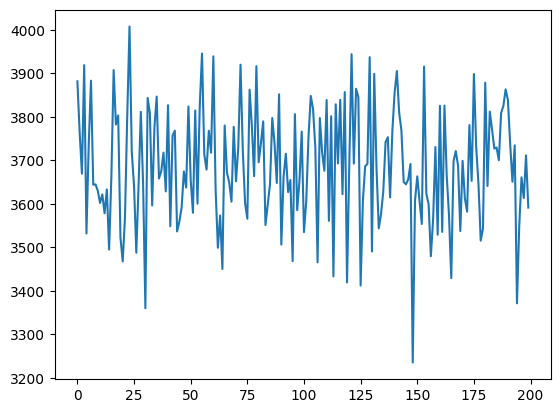

In [ ]:
############################### Generate initial dataset ###############################


assert args.dims > 0
assert f is not None
assert args.samples > 0

lower = f.lb
upper = f.ub

bounds = []
for idx in range(0, len(f.lb) ):
    bounds.append( ( float(f.lb[idx]), float(f.ub[idx])) )


#200 initial points
aaa = np.arange(f.lb[0], f.ub[0] + f.turn, f.turn).round(5)
input_X = np.random.choice(aaa,size=(200, args.dims))
input_y = []
input_y2 = []
for i in input_X:
    y1, y2 = fx(i)
    input_y.append(y1)
    input_y2.append(y2)
input_X = np.array(input_X)
input_y2 = np.array(input_y2)
print("")
print("="*20)
print("200 initial data points collection completed")
print("="*20)
print("")

plt.plot(input_y)

In [ ]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   Define the DOTS alghorithm

################################################################################

In [ ]:
################################# DOTS alghorithm ################################


class DOTS:
    def __init__(self, exploration_weight=None,f=None, model = None, name = None):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight
        self.model = model
        self.f = f
        self.name = name

    def choose(self, node):
        "Choose the best successor of node."
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            print('not seen before, randomly sampled!')
            return node.find_random_child()

        def evaluate(n):
            return n.value  # average reward
        log_N_vertex = math.log(self.N[node])
        def uct(n):
            "Upper confidence bound for trees"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value

        action = [p for p in range(0, len(node.tup))]
        self.children[node] = node.find_children(action,self.f,self.model)

        media_node = max(self.children[node], key=uct)
        node_rand = []
        # for i in range(len(list(self.children[node]))):
        ind=np.random.randint(0,len(list(self.children[node])),2) ##for computer memory consideration, choose only 2 random nodes in one rollout
        for i in ind:
              node_rand.append(list(self.children[node])[i].tup)

        if uct(media_node) > uct(node):
            return media_node, node_rand
        return node, node_rand

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def data_process(self,X,boards):
        new_x = []
        boards = np.array(boards)
        boards = np.unique(boards, axis=0)
        for i in boards:
          temp_x = np.array(i)
          same = np.all(temp_x==X, axis=1)
          has_true = any(same)
          if has_true == False:
            new_x.append(temp_x)
        new_x= np.array(new_x)
        print(f'unique number of boards: {len(new_x)}')
        return new_x

    def most_visit_node(self,X,top_n):
        N_visit = self.N
        childrens = [i for i in self.children]
        children_N = []
        X_top = []
        for child in childrens:
          child_tup = np.array(child.tup)
          same = np.all(child_tup==X, axis=1)
          has_true = any(same)
          if has_true == False:
            children_N.append(N_visit[child])
            X_top.append(child_tup)
        children_N = np.array(children_N)
        X_top = np.array(X_top)
        ind = np.argpartition(children_N, -top_n)[-top_n:]
        X_topN = X_top[ind]
        return X_topN

    def single_rollout(self,X,rollout_round,board_uct,num_list=[5,1,1]):
        boards = []
        boards_rand = []
        for i in range(0, rollout_round):
            self.do_rollout(board_uct)
            board_uct,board_rand = self.choose(board_uct)
            boards.append(list(board_uct.tup))
            boards_rand.append(list(board_rand))

        #visit nodes
        X_most_visit =  self.most_visit_node(X, num_list[1])

        #highest pred value nodes and random nodes
        new_x = self.data_process(X,boards)
        try:
            new_pred = self.model.predict(np.array(new_x).reshape(len(new_x),-1,1))
            new_pred = np.array(new_pred).reshape(len(new_x))
        except:
            pass
        boards_rand = np.vstack(boards_rand)
        new_rands = self.data_process(X,boards_rand)
        top_n = num_list[0]
        if len(new_x)>=top_n:
            ind = np.argsort(new_pred)[-top_n:]
            top_X =  new_x[ind]
            X_rand2 = [new_rands[random.randint(0, len(new_rands)-1)] for i in range(num_list[2])]
        elif len(new_x)==0:
            new_pred = self.model.predict(np.array(new_rands).reshape(len(new_rands),-1,1)).reshape(-1)
            ind = np.argsort(new_pred)[-top_n:]
            top_X =  new_rands[ind]
            X_rand2 = [new_rands[random.randint(0, len(new_rands)-1)] for i in range(num_list[2])]
        else:
            top_X = np.array(new_x)
            num_random = num_list[0] + num_list[2] - len(top_X)
            X_rand2 = [new_rands[random.randint(0, len(new_rands)-1)] for i in range(num_random)]
        try:
            top_X = np.concatenate([X_most_visit, top_X, X_rand2])
        except:
            top_X = np.concatenate([X_most_visit, top_X])

        return top_X

    def rollout(self, X,y,rollout_round,ratio,iteration):
        if self.name == 'rastrigin' or self.name == 'ackley' or self.name == 'levy':
            index_max = np.argmax(y)
            print(max(y))
            initial_X = X[index_max,:]
            values = self.model.predict(np.array(initial_X).reshape(1,-1,1))
            values = float(np.array(values).reshape(1))
            board_uct = opt_task(tup=tuple(initial_X), value=values, terminal=False)
            exp_weight = ratio * abs(max(y))
            self.exploration_weight = exp_weight
            ### starting rollout
            if self.name == 'rastrigin':
                num_list1=[18,2,0]
            else:
                num_list1=[15,3,2]
            top_X = self.single_rollout(X,rollout_round,board_uct,num_list=num_list1)


        else:
            if iteration % 100 < 80:
                UCT_low=False
            else:
                UCT_low=True

            #### make sure unique initial points
            ind = np.argsort(y)
            x_current_top = X[ind[-3:]]
            x_current_top = np.unique(x_current_top, axis = 0)
            i = 0
            while len(x_current_top) < 3:
                x_current_top=np.concatenate((x_current_top.reshape(-1,self.f.dims),X[ind[i-4]].reshape(-1,self.f.dims)), axis = 0)
                i-=1
                x_current_top = np.unique(x_current_top, axis = 0)

            ### starting rollout
            X_top=[]
            for i in range(3):
                initial_X = x_current_top[i]
                values = max(y)
                exp_weight = ratio * abs(values)
                if UCT_low ==True:
                    values = self.model.predict(np.array(initial_X).reshape(1,-1,1))
                    values = float(np.array(values).reshape(1))
                    exp_weight = ratio*0.5*values
                self.exploration_weight = exp_weight
                board_uct = opt_task(tup=tuple(initial_X), value=values, terminal=False)
                top_X = self.single_rollout(X,rollout_round,board_uct)
                X_top.append(top_X)

            top_X = np.vstack(X_top)
            top_X = top_X[:20]
        return top_X

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        count = 0
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
              return path
            unexplored = self.children[node] - self.children.keys()
            def evaluate(n):
              return n.value
            if count == 50:
                return path
            if unexplored:
              path.append(max(unexplored, key=evaluate))#
              return path
            node = self._uct_select(node)  # descend a layer deeper
            count+=1

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        action = [p for p in range(0, len(node.tup))]
        self.children[node] = node.find_children(action, self.f,self.model)

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        reward = node.reward(self.model)
        return reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
          self.N[node] += 1
          self.Q[node] += reward

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value
        uct_node = max(self.children[node], key=uct)
        return uct_node

class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """
    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True

_OT = namedtuple("opt_task", "tup value terminal")
class opt_task(_OT, Node):
    def find_children(board,action,f,model):
        if board.terminal:
            return set()
        turn = f.turn
        aaa = np.arange(f.lb[0], f.ub[0] + f.turn, f.turn).round(5)
        all_tup=[]
        for index in action:
            tup = list(board.tup)
            flip = random.randint(0,5)
            if   flip ==0:
              tup[index] += turn
            elif flip ==1:
                tup[index] -= turn
            elif flip ==2:
              for i in range(int(f.dims/5)):
                index_2 = random.randint(0, len(tup)-1)
                tup[index_2] = np.random.choice(aaa)
            elif flip ==3:
              for i in range(int(f.dims/10)):
                index_2 = random.randint(0, len(tup)-1)
                tup[index_2] = np.random.choice(aaa)
            elif flip ==4:
                tup[index] = np.random.choice(aaa)
            elif flip ==5:
                tup[index] = np.random.choice(aaa)
            tup[index] = round(tup[index],5)

            tup = np.array(tup)
            ind1 = np.where(tup>f.ub[0])[0]
            if len(ind1) > 0:
                tup[ind1] = f.ub[0]
            ind1 = np.where(tup<f.lb[0])[0]
            if len(ind1) > 0:
                tup[ind1] = f.lb[0]
            all_tup.append(tup)

        all_value = model.predict(np.array(all_tup).reshape(len(all_tup),f.dims,1))
        is_terminal=False
        return  {opt_task(tuple(t), v[0], is_terminal) for t, v in  zip(all_tup,all_value)}

    def reward(board,model):
        values = model.predict(np.array(board.tup).reshape(1,-1,1))
        values = float(np.array(values).reshape(1))
        return values
    def is_terminal(board):
        return board.terminal


In [ ]:




################################ End of Part II ################################






################################################################################
> # **Part - III**

*   Define the CNN model

################################################################################

Surrogate model defined


2024-04-24 03:10:15.363478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-24 03:10:15.363998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 3090 Ti computeCapability: 8.6
coreClock: 1.905GHz coreCount: 84 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 938.86GiB/s
2024-04-24 03:10:15.364096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-24 03:10:15.364603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-24 03:10:15.365061: I tensorflow/core/c

Epoch 1/500


2024-04-24 03:10:16.244646: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-04-24 03:10:16.590481: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-04-24 03:10:17.094073: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 03:10:17.094096: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2024-04-24 03:10:17.094318: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 03:10:17.094347: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-04-24 03:10:17.098244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

3/3 [==============================] - 2s 98ms/step - loss: 99.9259 - val_loss: 99.5941

Epoch 00001: val_loss improved from inf to 99.59408, saving model to NN.h5
Epoch 2/500
3/3 [==============================] - 0s 10ms/step - loss: 99.3024 - val_loss: 98.1683

Epoch 00002: val_loss improved from 99.59408 to 98.16829, saving model to NN.h5
Epoch 3/500
3/3 [==============================] - 0s 11ms/step - loss: 97.3022 - val_loss: 93.9236

Epoch 00003: val_loss improved from 98.16829 to 93.92361, saving model to NN.h5
Epoch 4/500
3/3 [==============================] - 0s 10ms/step - loss: 91.5488 - val_loss: 82.4176

Epoch 00004: val_loss improved from 93.92361 to 82.41759, saving model to NN.h5
Epoch 5/500
3/3 [==============================] - 0s 10ms/step - loss: 76.4347 - val_loss: 53.2845

Epoch 00005: val_loss improved from 82.41759 to 53.28447, saving model to NN.h5
Epoch 6/500
3/3 [==============================] - 0s 10ms/step - loss: 38.7057 - val_loss: 16.6640

Epoch 00006

3/3 [==============================] - 0s 11ms/step - loss: 2.2308 - val_loss: 3.9687

Epoch 00052: val_loss did not improve from 3.19154
Epoch 53/500
3/3 [==============================] - 0s 10ms/step - loss: 2.7903 - val_loss: 3.4983

Epoch 00053: val_loss did not improve from 3.19154
Epoch 54/500
3/3 [==============================] - 0s 10ms/step - loss: 2.6502 - val_loss: 3.9989

Epoch 00054: val_loss did not improve from 3.19154
Epoch 55/500
3/3 [==============================] - 0s 10ms/step - loss: 2.7061 - val_loss: 3.2772

Epoch 00055: val_loss did not improve from 3.19154
Epoch 56/500
3/3 [==============================] - 0s 10ms/step - loss: 2.6305 - val_loss: 3.4353

Epoch 00056: val_loss did not improve from 3.19154
Epoch 57/500
3/3 [==============================] - 0s 11ms/step - loss: 2.7136 - val_loss: 4.2652

Epoch 00057: val_loss did not improve from 3.19154
Epoch 58/500
3/3 [==============================] - 0s 10ms/step - loss: 2.8280 - val_loss: 3.2518

Epoch 0

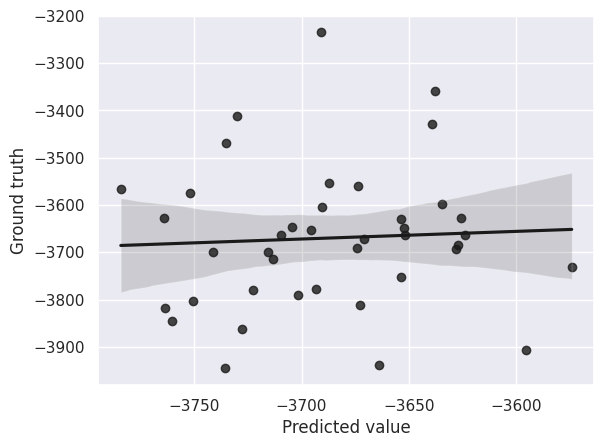

In [ ]:
################################ Define the CNN model ################################


class model_training:
    def __init__(self, f = None, dims=10, learning_rate = 0.001):
        self.f = f
        self.dims    = dims
        self.learning_rate = learning_rate

    def __call__(self, X,y, verbose = False):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if self.f == 'ackley':
            if self.dims <= 100:
                model = Sequential()
                model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=(self.dims, 1)))
                model.add(MaxPooling1D(pool_size=2, strides=1))
                model.add(Dropout(0.2))
                model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(MaxPooling1D(pool_size=2, strides=1))
                model.add(Dropout(0.2))
                model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(Flatten())
                model.add(Dense(128,activation='elu'))
                model.add(Dense(64,activation='elu'))
                model.add(Dense(1,activation='linear'))
                model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
            else:
                model = Sequential()
                model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=(self.dims, 1)))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Dropout(0.2))
                model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Dropout(0.2))
                model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(MaxPooling1D(pool_size=2, strides=1))
                model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(Conv1D(4, kernel_size=3, strides=1, padding='same', activation='elu'))
                model.add(Flatten())
                model.add(Dense(64,activation='elu'))
                model.add(Dense(1,activation='linear'))
                model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')

        elif self.f == 'rastrigin':
            model = Sequential([
                layers.Conv1D(256,kernel_size=5,strides=1,padding='same', activation='elu', input_shape=(self.dims,1)),
                layers.LayerNormalization(),
                layers.Conv1D(128,kernel_size=5,strides=2, padding='same', activation='elu'),
                layers.Conv1D(64,kernel_size=3,strides=2, padding='same', activation='elu'),
                layers.Conv1D(32,kernel_size=3,strides=1, padding='same', activation='elu'),
                layers.Conv1D(16,kernel_size=3,strides=1, padding='same', activation='elu'),
                layers.Conv1D(8,kernel_size=3,strides=1, padding='same', activation='elu'),
                layers.Flatten(),
                Dense(128, activation='elu'),
                Dense(64, activation='elu'),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_absolute_percentage_error')

        elif self.f == 'rosenbrock':
            model = Sequential()
            model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=(self.dims, 1)))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2, strides=1))
            model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Conv1D(4, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Flatten())
            model.add(Dense(64,activation='elu'))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')


        elif self.f == 'griewank':
            model = Sequential()
            model.add(Lambda(lambda x: x / 600, input_shape=(self.dims, 1)))
            model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2, strides=1))
            model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Conv1D(4, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Flatten())
            model.add(Dense(64,activation='elu'))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')


        elif self.f == 'levy':
            model = Sequential([
                layers.Lambda(lambda x: x / 10, input_shape=(self.dims, 1)),
                layers.Conv1D(256,kernel_size=5,strides=1,padding='same', activation='elu'),
                # layers.LayerNormalization(),
                layers.Conv1D(128,kernel_size=5,strides=2, padding='same', activation='elu'),
                layers.Conv1D(64,kernel_size=3,strides=2, padding='same', activation='elu'),
                layers.Conv1D(32,kernel_size=3,strides=1, padding='same', activation='elu'),
                layers.Conv1D(16,kernel_size=3,strides=1, padding='same', activation='elu'),
                layers.Conv1D(8,kernel_size=3,strides=1, padding='same', activation='elu'),
                layers.Flatten(),
                Dense(128, activation='elu'),
                Dense(64, activation='elu'),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_absolute_percentage_error')


        elif self.f == 'schwefel':
            model = Sequential([
                layers.Lambda(lambda x: x / 1000, input_shape=(self.dims, 1)),
                layers.Conv1D(256,kernel_size=5,padding='same', activation='elu'),
                # layers.LayerNormalization(),
                layers.Conv1D(128,kernel_size=5, padding='same', activation='elu'),
                layers.MaxPooling1D(pool_size=2),
                layers.Conv1D(64,kernel_size=5, padding='same', activation='elu'),
                layers.Conv1D(32,kernel_size=5, padding='same', activation='elu'),
                layers.MaxPooling1D(pool_size=2),
                layers.Conv1D(16,kernel_size=5, padding='same', activation='elu'),
                layers.Conv1D(8,kernel_size=5, padding='same', activation='elu'),
                layers.Conv1D(4,kernel_size=5, padding='same', activation='elu'),
                layers.Flatten(),
                Dense(128, activation='elu'),
                Dense(64, activation='elu'),
                Dense(32, activation='elu'),
                Dense(16, activation='elu'),
                Dense(8, activation='elu'),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_absolute_percentage_error')

        elif self.f == 'michalewicz':
            model = Sequential()
            model.add(Lambda(lambda x: x / np.pi, input_shape=(self.dims, 1)))
            model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(MaxPooling1D(pool_size=2, strides=1))
            model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='elu'))
            model.add(Flatten())
            model.add(Dense(64,activation='elu'))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        else:
            model = Sequential()
            model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(self.dims, 1)))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
            model.add(MaxPooling1D(pool_size=2, strides=1))
            model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='relu'))
            model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='relu'))
            model.add(Conv1D(4, kernel_size=3, strides=1, padding='same', activation='relu'))
            model.add(Flatten())
            model.add(Dense(64,activation='relu'))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')


        mc = ModelCheckpoint("NN.h5", monitor='val_loss', mode='min', verbose=verbose, save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
        model.fit(X_train.reshape(len(X_train),self.dims,1), y_train, batch_size=64, epochs=500, validation_data=(X_test.reshape(len(X_test),self.dims,1), y_test), callbacks=[early_stop,mc],verbose=verbose)

        model =  keras.models.load_model("NN.h5")
        y_pred = model.predict(X_test.reshape(len(X_test),self.dims,1))

        R=stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
        R=np.asarray(R).round(3)
        MAE= metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
        MAPE= metrics.mean_absolute_percentage_error(y_test.reshape(-1), y_pred.reshape(-1))
        MAE=np.asarray(MAE).round(5)
        MAPE=np.asarray(MAPE).round(5)
        print("Model performance: R2",R**2,"MAE",MAE,"MAPE",MAPE)

        plt.figure()
        sns.set()
        sns.regplot(x=y_pred, y=y_test, color='k')
        plt.xlabel('Predicted value')
        plt.ylabel('Ground truth')

        return model



################################ Define the CNN model ################################

nn = model_training(f=args.func, dims=args.dims)

print("Surrogate model defined")

model = nn(input_X,input_y2,verbose = 1)
model.summary()


In [ ]:



################################ End of Part III ###############################




################################################################################
> # **Part - IV**

*   Optimization using DOTS

################################################################################


Input description:
*   input_X: initial data
*   input_y2: initial label

Output description:

*   top_X: newly sampled data
*   top_y: new labels


Model performance: R2 0.005929 MAE 117.39342 MAPE 0.03237
-3234.996091293762
unique number of boards: 200
unique number of boards: 398

#samples: 201 total samples: 201
current best f(x): 3201.5996601125016
current best x: [-2.8 -2.7 -3.8  3.1  3.6  2.5  0.9 -4.2 -2.8 -1.9 -1.5  4.5 -2.7  0.9
 -3.   2.4  0.5  1.4 -1.1  0.1 -0.7  0.5 -0.6  5.  -0.6  2.   0.5  3.3
  0.6  1.6  0.2 -1.3  0.7  0.4  3.2  1.1  3.7  3.1  0.4 -4.1 -2.3  0.2
 -3.4  4.  -1.8  1.1 -1.8  3.2  4.6  2.8  3.5 -4.9  1.2 -2.7  2.4 -1.3
  2.3  0.6  3.3 -1.1 -0.2 -0.8  3.9 -4.8 -3.  -3.2  1.   4.2  1.5  2.2
  0.2  0.7  0.4 -0.2  0.5 -2.3  0.6 -2.1  1.2 -4.8 -1.7 -1.2 -0.7  2.
  2.   0.7 -1.1  4.7  1.8  1.  -0.   2.   2.7  3.2  0.9 -4.9  1.1 -2.4
  2.9 -2.3  1.9 -1.3  3.3 -4.6 -1.3 -3.3  1.2 -0.3  1.4 -1.9  2.7 -4.2
 -2.8 -1.9 -1.1 -0.3 -1.6 -1.2 -3.3  4.8 -0.5  2.7 -1.2  2.4  0.4  1.
 -1.   3.7  0.2  3.   1.7  2.3  3.3  3.8  1.7 -2.1  2.2 -1.8  4.9 -4.6
 -3.1 -1.1 -1.6  4.8 -1.8  5.  -0.   4.   0.2  1.   0.1  0.3 -0.6  2.

Model performance: R2 0.8244640000000001 MAE 100.38027 MAPE 0.0275
-2632.134731743766
unique number of boards: 200
unique number of boards: 400

#samples: 221 total samples: 221
current best f(x): 2492.3940519687685
current best x: [-2.8 -2.7 -3.8  3.1  0.9  2.5  0.2 -4.2 -2.8 -1.9 -1.5  0.7 -0.2  0.2
 -0.1  0.1 -0.   0.1  0.   0.   0.  -0.1  0.5  5.  -0.6  2.  -0.5  3.3
 -0.3  1.1 -0.1  0.3 -0.1  0.2 -0.2 -0.   0.9  0.2  2.  -4.1 -1.5 -1.9
  0.4  4.  -0.9  1.1 -1.8  4.9  4.6  2.8  3.5 -4.9  0.1 -1.1  0.3 -0.7
  0.1 -0.2  0.5 -3.8 -0.2 -0.8  2.  -4.8 -0.3 -0.3 -0.1 -0.1 -0.1  0.
 -0.   0.   0.   0.  -0.  -0.3  0.6 -0.   1.2 -4.8 -1.7 -1.2 -0.7  2.9
  0.6  0.5 -0.2  0.2 -0.3  0.2 -0.   2.   2.7  3.2  4.6 -4.9  0.3 -2.4
  1.5 -2.3  0.7 -1.3  1.7 -4.6 -0.4 -1.3  1.2 -0.3  1.4 -0.3  2.7 -4.2
 -0.8 -1.9  1.1 -1.2 -0.9 -1.2  0.1  4.8 -0.5  1.6 -1.2  2.4 -0.   1.
 -1.   3.7  0.2  3.   0.1  4.9  3.3  3.8  1.7 -4.7  0.1 -1.8  4.9 -4.6
 -3.1 -3.9 -1.6  4.8 -0.5  0.8 -0.   0.4  0.1  0.2  0.   0. 

Model performance: R2 0.952576 MAE 90.86483 MAPE 0.02516
-2077.4430323062716
unique number of boards: 200
unique number of boards: 398

#samples: 241 total samples: 241
current best f(x): 1827.5133721937705
current best x: [-2.8 -2.7 -2.6  3.1  0.9  0.1  0.2 -4.2 -0.9 -0.4  0.1 -0.1  0.   0.
  0.   0.  -0.   0.   0.   0.  -0.1 -0.1  0.5  5.   1.8  1.4 -0.4  0.4
 -0.1  0.2 -0.1  0.1  0.   0.1  0.  -0.   0.   0.1  0.1  0.2 -0.3 -0.
  0.4  1.7  0.1  1.1 -0.5  4.9  1.8  2.8  3.5 -4.9  0.1 -1.1  0.3 -0.7
  0.1 -0.3  0.5 -0.5 -0.2 -0.5  0.1 -0.2  0.  -0.1  0.   0.   0.   0.
 -0.   0.   0.   0.  -0.  -0.1  0.1 -0.   0.4 -4.8 -1.7 -1.2  0.2 -0.2
  0.   0.   0.   0.1  0.   0.1 -0.  -0.1 -0.1 -0.2  0.7 -0.1  0.3 -1.2
  4.  -2.3  0.7 -1.3  3.5 -4.6 -0.4 -1.3  0.5 -0.3  0.6 -0.3  1.7 -5.
 -0.8 -1.9  1.1 -1.2 -0.2 -1.2  0.1  4.8 -0.5  1.6 -0.8  2.4 -0.   1.
 -0.   0.7  0.2  0.5  0.1  4.9  3.3  3.8  2.8 -4.7  0.1 -1.8  1.1 -4.6
 -1.5 -1.8 -0.  -0.3 -0.1 -0.2 -0.   0.   0.   0.   0.   0.   0.  -0.
 -

Model performance: R2 0.974169 MAE 79.29678 MAPE 0.02271
-1389.6950716312654
unique number of boards: 200
unique number of boards: 400

#samples: 261 total samples: 261
current best f(x): 1214.3659213500125
current best x: [-2.8  0.6 -1.6  0.2  0.2  0.1  0.   0.   0.   0.   0.1  0.   0.   0.
  0.   0.  -0.   0.   0.   0.  -0.   0.   0.2 -0.   0.3  0.1  0.2  0.1
  0.   0.1  0.   0.1  0.   0.   0.  -0.   0.   0.   0.   0.   0.  -0.
  0.   0.   0.  -0.  -0.1  0.1  1.  -1.   3.5 -4.9  1.1 -1.1  0.3 -0.3
 -0.  -0.1 -0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   0.   0.   0.  -0.   0.   0.1 -0.   0.4 -1.   0.9 -0.5  0.2 -0.2
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.1  0.   0.   0.
  0.1  0.   0.2 -0.3  1.3 -4.6  4.9 -1.   0.5 -0.3  0.6 -0.3  1.7 -5.
  4.5 -1.9  1.1 -1.2 -0.2 -1.2  1.6  4.8 -2.   1.6 -0.8  1.4 -0.1  0.2
 -0.   0.3  0.2  0.4  0.1 -1.4  3.3 -1.6  2.8 -4.7  1.8 -1.8  4.8 -4.6
  4.  -0.8 -0.  -0.3  0.  -0.1 -0.   0.   0.   0.   0.   0.   0.  -0.
 -

Model performance: R2 0.986049 MAE 73.04576 MAPE 0.02142
-901.9215028125263
unique number of boards: 200
unique number of boards: 400

#samples: 281 total samples: 281
current best f(x): 652.1508230375284
current best x: [-0.8 -0.  -0.6  0.1  0.   0.1  0.   0.   0.   0.   0.1  0.   0.   0.
  0.   0.   0.2  0.   0.   0.  -0.   0.  -0.3 -0.  -0.2  0.1  0.2  0.1
  0.   0.1  0.   0.1  0.   0.   0.  -0.   0.   0.   0.   0.   0.  -0.
  0.   0.   0.  -0.   0.   0.1 -0.  -0.2  0.9  0.8  1.1  0.4  0.3  0.1
  0.1  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.3  0.
 -0.   0.   0.   0.  -0.   0.   0.1 -0.   0.2 -0.1  0.2 -0.1  0.2  0.
  0.   0.   0.4  0.   0.   0.  -0.   0.   0.   0.   0.1  0.   0.   0.
  0.1  0.   0.2 -0.  -0.2 -0.8 -0.3 -1.   0.5 -0.3  0.  -0.2  0.3 -0.5
 -0.1 -0.9 -0.1 -0.3 -0.2 -0.2  0.4  0.2  1.2  0.7 -0.   0.1  0.   0.1
 -0.   0.1  0.   0.   0.1  0.1  0.1 -0.3  0.6  1.9  1.8 -1.8  4.8 -0.8
 -1.2 -0.8 -0.  -0.2  0.   0.   0.1  0.   0.   0.   0.   0.   0.  -0.
 -0.

Model performance: R2 0.990025 MAE 72.25255 MAPE 0.02188
-412.6658946687937
unique number of boards: 196
unique number of boards: 399

#samples: 301 total samples: 301
current best f(x): 344.4948483250778
current best x: [ 0.1 -0.1  0.1 -0.1  0.1  0.1  0.1  0.   0.1 -0.1  0.1 -0.1  0.  -0.1
  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.1
  0.  -0.1  0.   0.   0.1 -0.1  0.2 -0.   0.  -0.1  0.1 -0.1  0.  -0.1
  0.   0.   0.1 -0.1  0.2 -0.1 -0.  -0.1  0.1  0.   0.1 -0.1  0.2  0.
  0.1  0.   0.1  0.   0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1
  0.1 -0.1  0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.  -0.1  0.1  0.
  0.1 -0.2  0.  -0.1  0.  -0.1  0.2  0.   0.  -0.1  0.2  0.   0.1 -0.1
  0.1 -0.1  0.1 -0.1  0.1 -0.   0.1  0.   0.1 -0.1  0.1 -0.1  0.  -0.1
  0.  -0.1  0.2 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.  -0.2
  0.1  0.   0.1  0.   0.1 -0.2  0.  -0.1  0.1  0.   0.1 -0.1  0.  -0.1
  0.  -0.1 -0.  -0.2  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1


Model performance: R2 0.988036 MAE 90.23041 MAPE 0.02701
-332.51501826882736
unique number of boards: 200
unique number of boards: 399

#samples: 321 total samples: 321
current best f(x): 332.51501826882736
current best x: [ 0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.1  0.  -0.1  0.  -0.1
  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.1
  0.  -0.1  0.   0.   0.1 -0.1  0.2 -0.   0.  -0.1  0.1 -0.1  0.1 -0.1
  0.   0.   0.1 -0.1  0.1 -0.1 -0.  -0.1  0.1  0.   0.1 -0.1  0.2  0.
  0.1  0.   0.1  0.   0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1
  0.1 -0.1  0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.  -0.1  0.1  0.
  0.1 -0.2  0.  -0.1  0.  -0.1  0.2  0.   0.  -0.1  0.2  0.   0.1 -0.1
  0.1 -0.1  0.1 -0.1  0.1 -0.   0.1  0.   0.1 -0.1  0.1 -0.1  0.  -0.1
  0.  -0.1  0.2 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.  -0.1  0.  -0.2
  0.1  0.   0.1  0.   0.1 -0.2  0.  -0.1  0.1  0.   0.1 -0.1  0.  -0.1
  0.  -0.1 -0.  -0.2  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.

Model performance: R2 0.992016 MAE 80.08039 MAPE 0.02697
-332.51501826882736
unique number of boards: 179
unique number of boards: 399

#samples: 341 total samples: 341
current best f(x): 332.51501826882736
current best x: [ 0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.1  0.  -0.1  0.  -0.1
  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.1
  0.  -0.1  0.   0.   0.1 -0.1  0.2 -0.   0.  -0.1  0.1 -0.1  0.1 -0.1
  0.   0.   0.1 -0.1  0.1 -0.1 -0.  -0.1  0.1  0.   0.1 -0.1  0.2  0.
  0.1  0.   0.1  0.   0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1 -0.1
  0.1 -0.1  0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.  -0.1  0.1  0.
  0.1 -0.2  0.  -0.1  0.  -0.1  0.2  0.   0.  -0.1  0.2  0.   0.1 -0.1
  0.1 -0.1  0.1 -0.1  0.1 -0.   0.1  0.   0.1 -0.1  0.1 -0.1  0.  -0.1
  0.  -0.1  0.2 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.  -0.1  0.  -0.2
  0.1  0.   0.1  0.   0.1 -0.2  0.  -0.1  0.1  0.   0.1 -0.1  0.  -0.1
  0.  -0.1 -0.  -0.2  0.  -0.1  0.1 -0.1  0.1 -0.1  0.1  0.   0.1 -0.

Model performance: R2 0.994009 MAE 67.41107 MAPE 0.02196
-332.51501826882736
unique number of boards: 198
unique number of boards: 399

#samples: 361 total samples: 361
current best f(x): 186.6843651750487
current best x: [ 0.1 -0.1  0.1  0.   0.1  0.   0.1  0.   0.1 -0.1  0.   0.   0.  -0.1
  0.   0.   0.1  0.   0.1  0.   0.1  0.   0.1  0.   0.1  0.   0.  -0.1
  0.   0.   0.   0.   0.1  0.   0.  -0.   0.  -0.1  0.  -0.1  0.1 -0.1
  0.   0.   0.1 -0.1  0.  -0.1 -0.  -0.1  0.   0.   0.1  0.   0.1  0.
  0.1  0.   0.1  0.   0.1  0.   0.   0.   0.1  0.   0.   0.   0.1  0.
  0.1  0.   0.1 -0.1  0.   0.   0.1  0.1  0.1  0.   0.  -0.1  0.1  0.
  0.1 -0.1  0.  -0.1  0.  -0.1 -0.   0.   0.   0.   0.1  0.   0.1  0.
  0.1  0.   0.1  0.   0.1 -0.   0.1  0.   0.   0.   0.1 -0.1  0.   0.
  0.  -0.1  0.1 -0.1  0.  -0.1  0.1 -0.1  0.1 -0.1  0.  -0.1  0.  -0.2
  0.1  0.   0.1  0.   0.1 -0.2  0.  -0.1  0.   0.   0.1  0.   0.  -0.1
  0.  -0.1 -0.   0.   0.  -0.1  0.   0.   0.1  0.   0.1  0.   0.1  0.
 -0

Model performance: R2 0.994009 MAE 65.3245 MAPE 0.02411
-101.02150281252625
unique number of boards: 140
unique number of boards: 399

#samples: 381 total samples: 381
current best f(x): 9.599150281252605
current best x: [ 0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1  0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   0.

Model performance: R2 0.994009 MAE 70.23389 MAPE 0.05141
-1.9198300562504755
unique number of boards: 149
unique number of boards: 400

#samples: 401 total samples: 401
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 62.29442 MAPE 0.02499
-1.9198300562504755
unique number of boards: 141
unique number of boards: 399

#samples: 421 total samples: 421
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.994009 MAE 74.63534 MAPE 0.04087
-1.9198300562504755
unique number of boards: 130
unique number of boards: 398

#samples: 441 total samples: 441
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 51.43027 MAPE 0.02302
-1.9198300562504755
unique number of boards: 130
unique number of boards: 400

#samples: 461 total samples: 461
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 65.01741 MAPE 0.03871
-1.9198300562504755
unique number of boards: 119
unique number of boards: 399

#samples: 481 total samples: 481
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 50.03948 MAPE 0.03647
-1.9198300562504755
unique number of boards: 136
unique number of boards: 400

#samples: 501 total samples: 501
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 67.29777 MAPE 0.02812
-1.9198300562504755
unique number of boards: 122
unique number of boards: 400

#samples: 521 total samples: 521
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 52.90011 MAPE 0.02475
-1.9198300562504755
unique number of boards: 126
unique number of boards: 399

#samples: 541 total samples: 541
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 56.13999 MAPE 0.02899
-1.9198300562504755
unique number of boards: 118
unique number of boards: 398

#samples: 561 total samples: 561
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 51.72584 MAPE 0.03071
-1.9198300562504755
unique number of boards: 121
unique number of boards: 400

#samples: 581 total samples: 581
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 51.35338 MAPE 0.03496


/tmp/ipykernel_3981/67202100.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


-1.9198300562504755
unique number of boards: 121
unique number of boards: 399

#samples: 601 total samples: 601
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

Model performance: R2 0.996004 MAE 43.91607 MAPE 0.0253
-1.9198300562504755
unique number of boards: 105
unique number of boards: 398

#samples: 621 total samples: 621
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   0

Model performance: R2 0.998001 MAE 51.14401 MAPE 0.04545
-1.9198300562504755
unique number of boards: 116
unique number of boards: 399

#samples: 641 total samples: 641
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 46.28095 MAPE 0.02858
-1.9198300562504755
unique number of boards: 117
unique number of boards: 398

#samples: 661 total samples: 661
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

Model performance: R2 0.996004 MAE 53.18921 MAPE 0.03376
-1.9198300562504755
unique number of boards: 104
unique number of boards: 398

#samples: 681 total samples: 681
current best f(x): 1.9198300562504755
current best x: [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.  -0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -0.   

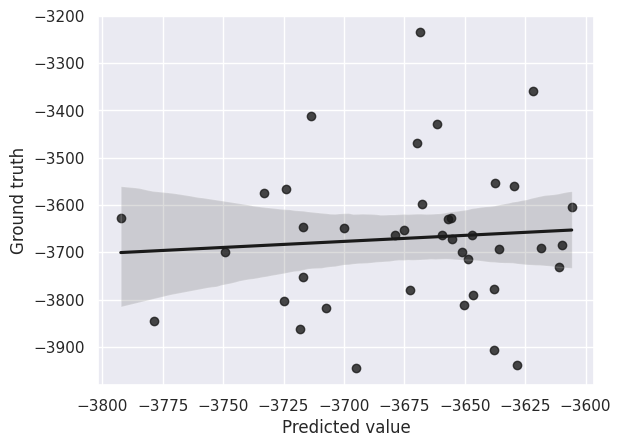

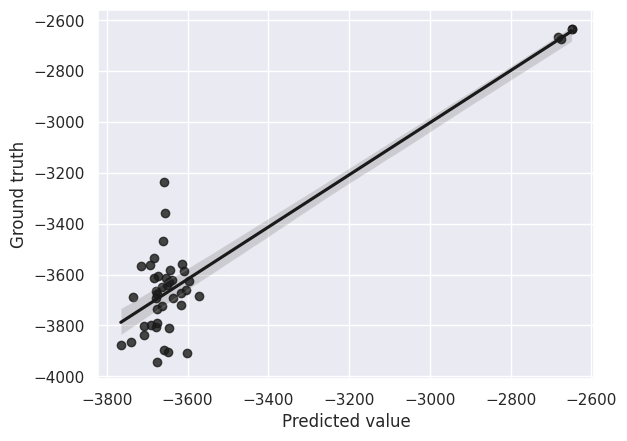

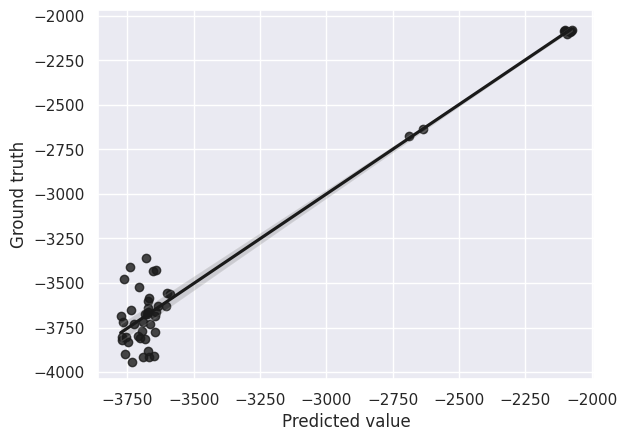

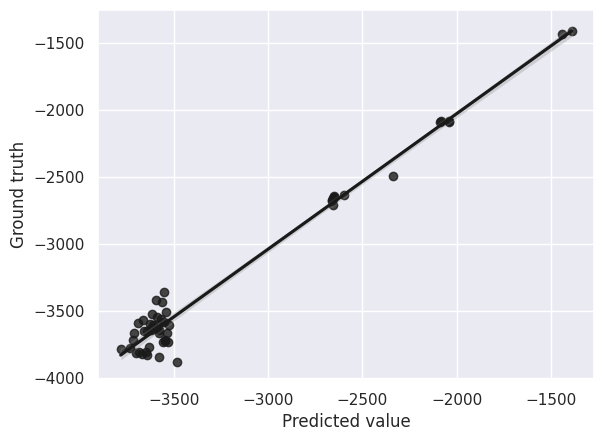

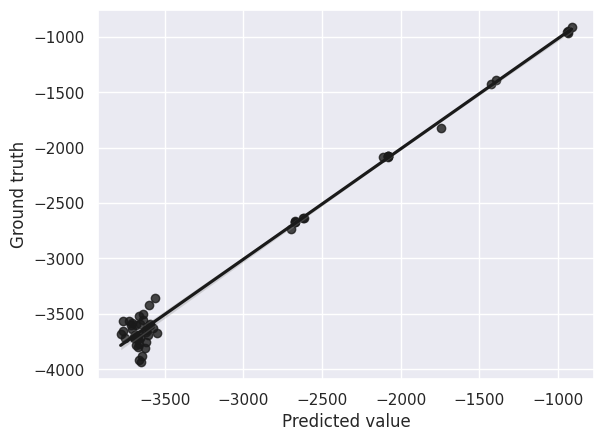

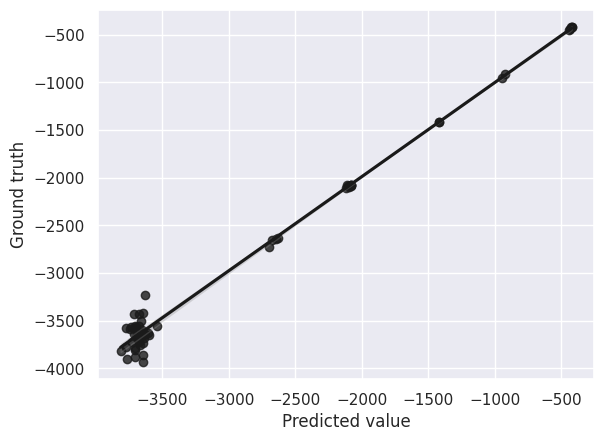

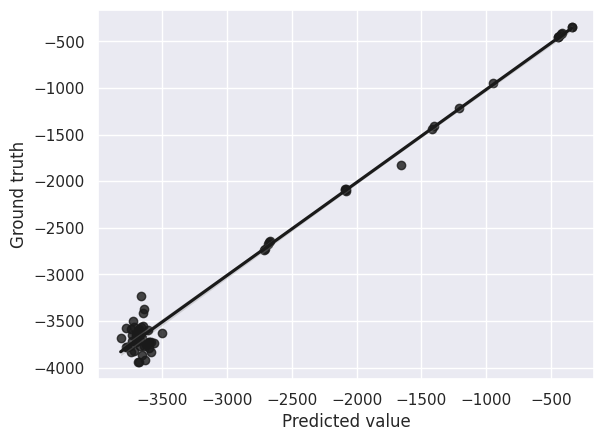

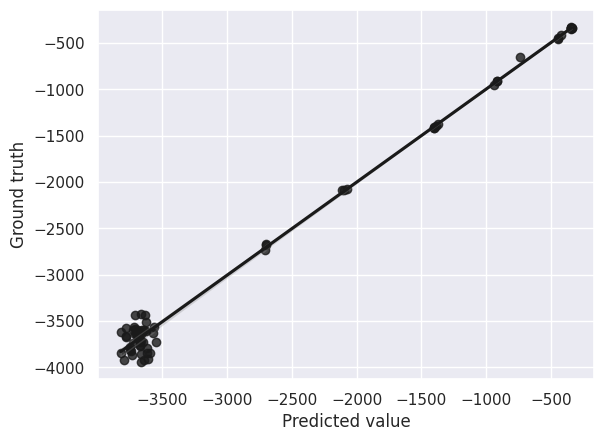

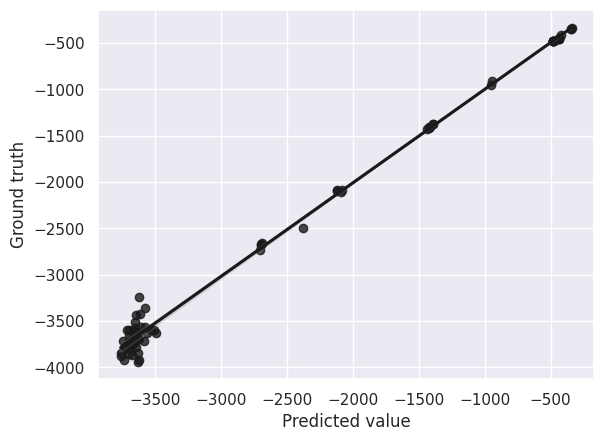

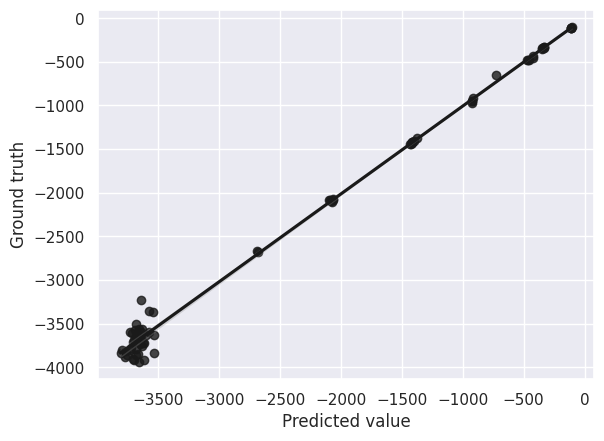

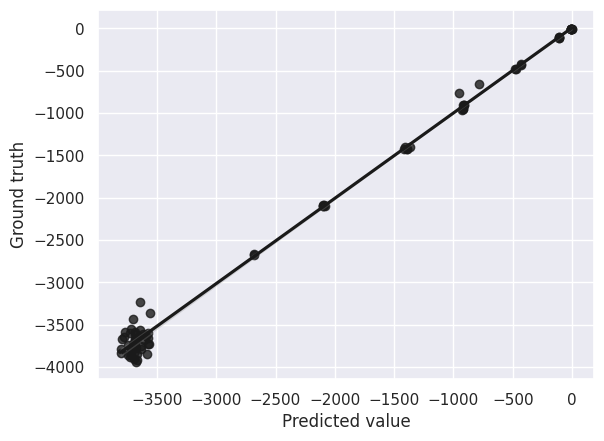

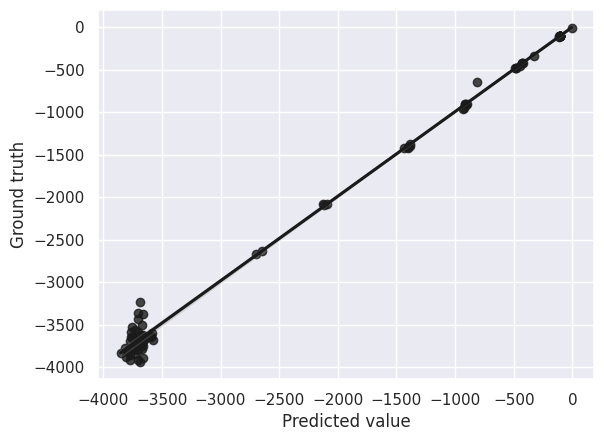

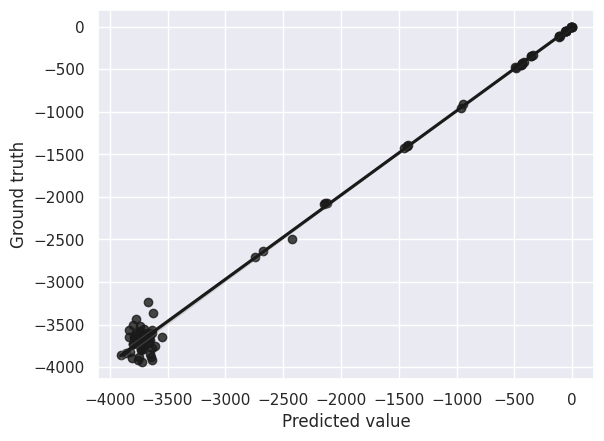

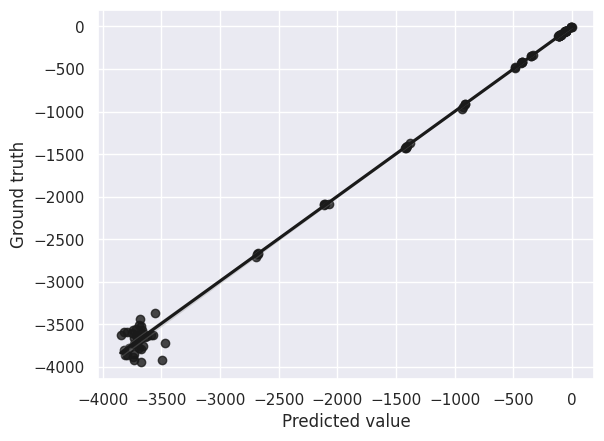

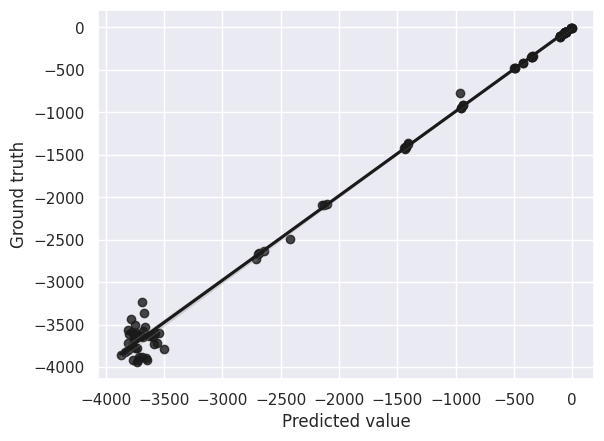

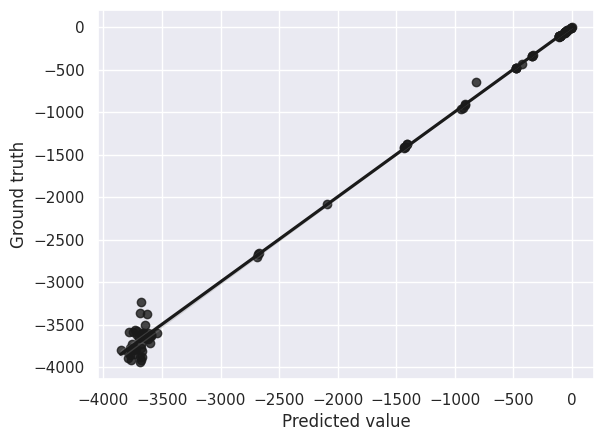

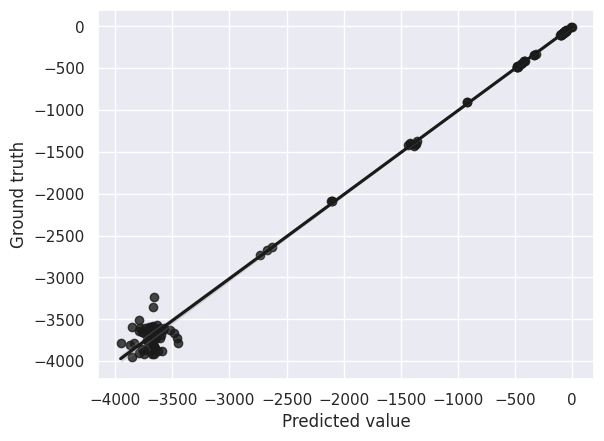

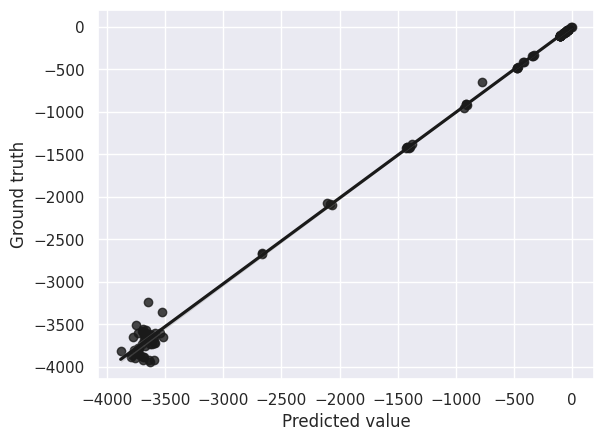

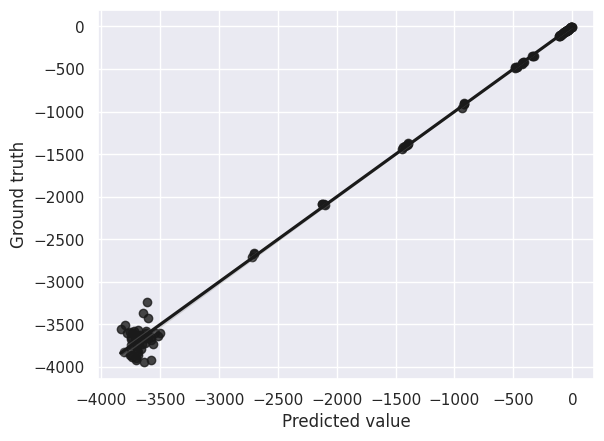

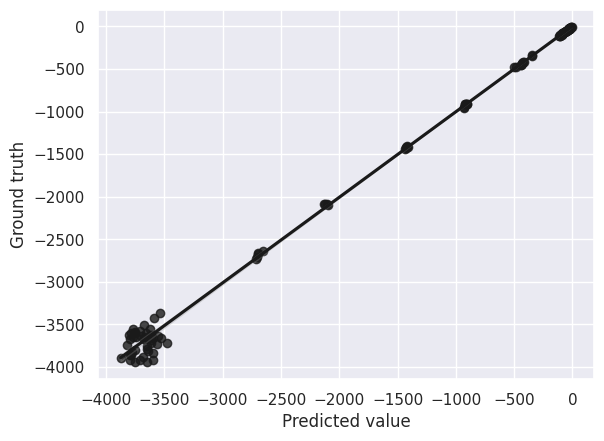

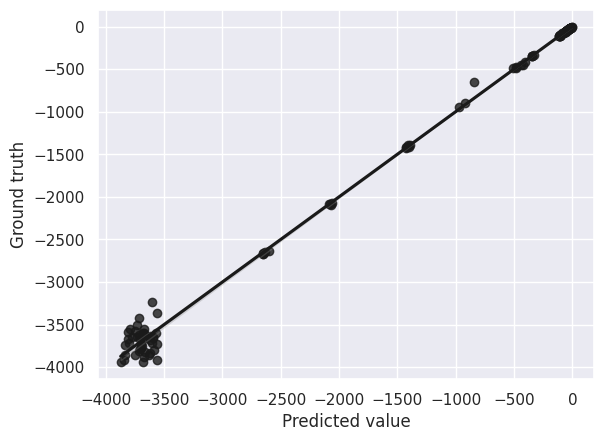

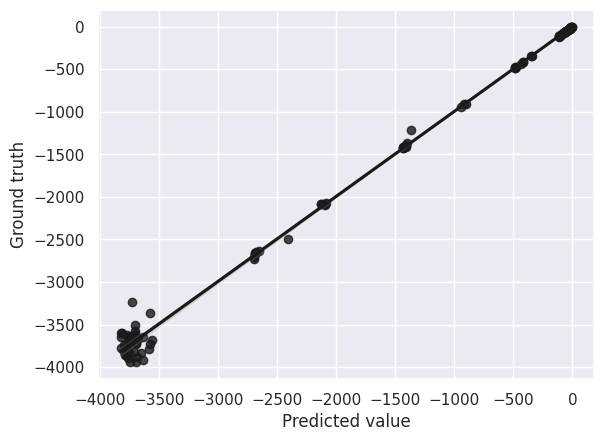

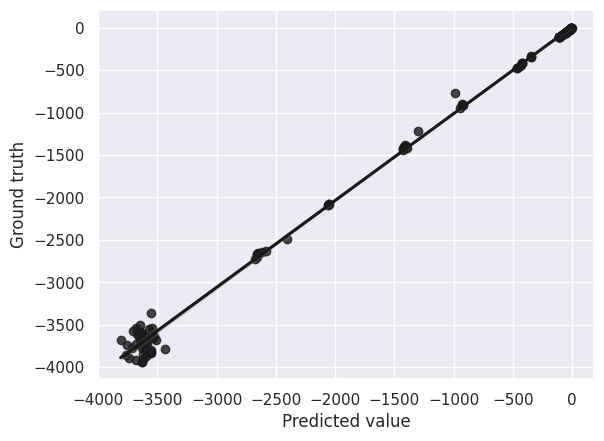

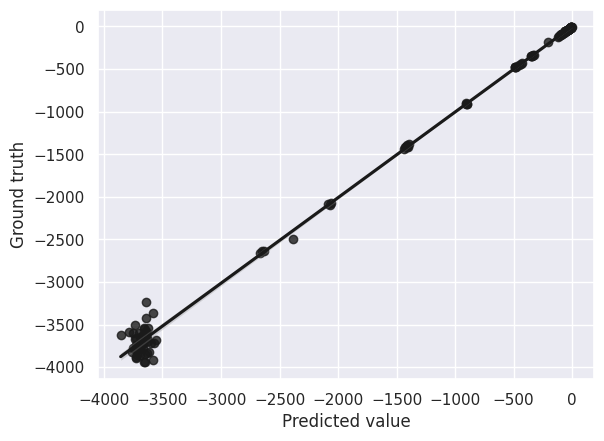

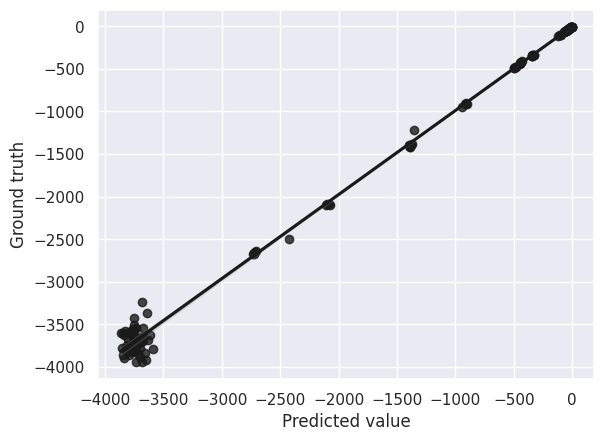

In [ ]:
################################ Optimization using DOTS ###############################

for i in range(args.samples//20):
    model = nn(input_X,input_y2)
    optimizer = DOTS(f=f, model=model, name = args.func)
    top_X = optimizer.rollout(input_X,input_y2,rollout_round,ratio,i)
    top_y = []
    for xx in top_X:
        y1, y2 = fx(xx)
        top_y.append(y2)
    top_y = np.array(top_y)
    input_X=np.concatenate((input_X,top_X),axis=0)
    input_y2=np.concatenate((input_y2,top_y))

    if f(input_X[np.argmax(input_y2)])[0] == 0:
        break


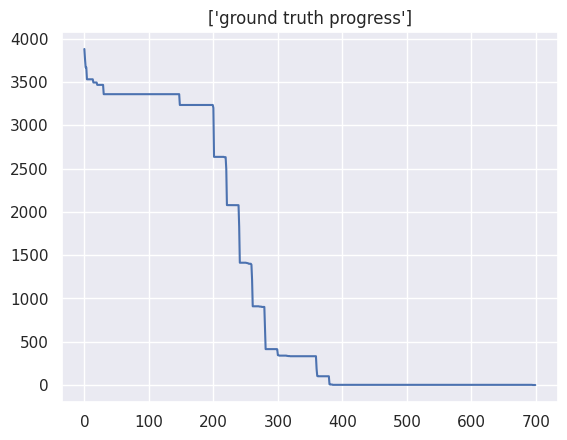

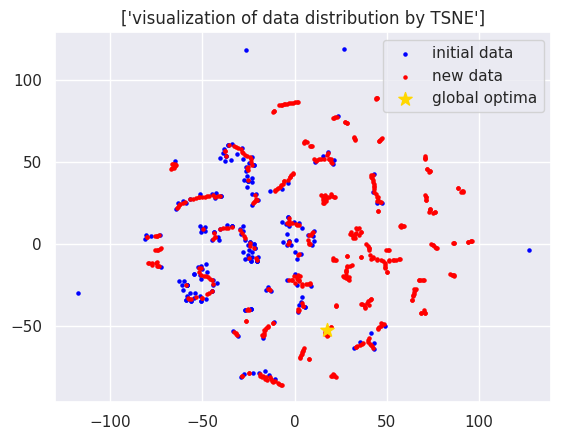

In [ ]:
################################ Visualization ###############################

results = np.load(f"{fx.tracker.foldername}/result.npy")
plt.plot(results)
plt.title(['ground truth progress'])
X_new = input_X + np.ones(args.dims)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_new)

plt.figure()
plt.scatter(X_embedded[:200,0], X_embedded[:200,1],s=5, color = 'blue')
plt.scatter(X_embedded[200:,0], X_embedded[200:,1],s=5, color = 'red')
plt.scatter(X_embedded[-1,0], X_embedded[-1,1],marker='*',s=100,color = 'gold')
plt.title(['visualization of data distribution by TSNE'])
plt.legend(['initial data','new data','global optima'])

In [ ]:



################################ End of Part IV ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################